In [1]:
import torch

# Limit to fraction of total GPU memory
torch.cuda.set_per_process_memory_fraction(0.5, device=0)

## Small processed data

### Load data for prediction

In [10]:
# Path to test data
test_data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_small_50kb/mouse_human/test/'

import os
import pandas as pd

# First load metadat
meta_csv_fn = os.path.join(test_data_dir, 'metadata.csv')
metadata_csv = pd.read_csv(meta_csv_fn)
print(metadata_csv.head())

import json

meta_fn = os.path.join(test_data_dir, 'metadata.json')
with open(meta_fn) as f:
    metadata = json.load(f)

print("\nWindow size", metadata['window_size'])
print("Context size", metadata['context_size'])
species_conds = metadata['species_condition_mapping']

for org, cond in species_conds.items():
    print(f"Conditions for {org}:")
    print([metadata['usage_conditions'][cond_idx] for cond_idx in cond])

      genome_id  chromosome    gene_id strand  window_with_context_start  \
0  human_GRCh37          22  hum.42245      -                   37176219   
1  human_GRCh37          22  hum.42250      -                   36902048   
2  human_GRCh37          22  hum.42250      -                   36952048   
3  human_GRCh37          22  hum.42257      -                   37127243   
4  human_GRCh37          22  hum.42299      +                   37291570   

   window_with_context_end  window_start  window_end  central_gene_start  \
0                 37236219      37181219    37231219            37196963   
1                 36962048      36907048    36957048            36907048   
2                 37012048      36957048    37007048            36957048   
3                 37187243      37132243    37182243            37142411   
4                 37351570      37296570    37346570            37309720   

   central_gene_end  n_donor_sites  n_acceptor_sites  species_id  
0          37215475

In [45]:
%load_ext autoreload
%autoreload 2
from alphagenome_pytorch import SpliceDataset

# Calculate target length (must be divisible by 128 for efficient batching)
target_length = (metadata['sequences_shape'][1] // 128) *128
print(f"Target sequence length: {target_length}")

# Calculate max donor/acceptor sites for junctions
max_donor = metadata_csv['n_donor_sites'].max()
max_acceptor = metadata_csv['n_acceptor_sites'].max()
max_sites = max(max_donor, max_acceptor)
max_sites = (max_sites // 10) * 10 
print(f"Max sites: {max_sites}")
max_donor_sites = max_sites
max_acceptor_sites = max_sites

# Species
species_mapping = {
    'human': 0,
    'mouse': 1
}

test_dataset = SpliceDataset(
    data_dir=test_data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Target sequence length: 59904
Max sites: 60
Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_small_50kb/mouse_human/test/


In [26]:
next(iter(test_dataset))

{'dna': tensor([1, 2, 3,  ..., 3, 1, 1]),
 'organism_index': tensor(0),
 'splice_donor_idx': tensor([28422, 29879, 31721, 32132, 32283, 32283, 32283, 32283, 32283, 32283,
         32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283,
         32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283,
         32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283,
         32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283,
         32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283, 32283]),
 'splice_acceptor_idx': tensor([15694, 28531, 30011, 31788, 31788, 31788, 31788, 31788, 31788, 31788,
         31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788,
         31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788,
         31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788,
         31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788, 31788,
         31788

### Check that the inputs are correctly encoded

The genomic coordinates of the first sequence in the test set.

In [40]:
import os
import pandas as pd
meta_csv_fn = os.path.join(test_data_dir, "metadata.csv")
meta_csv = pd.read_csv(meta_csv_fn)

i=0
chr = str(meta_csv.loc[i, 'chromosome'])
start = int(meta_csv.loc[i, 'window_with_context_start'])
end = int(meta_csv.loc[i, 'window_with_context_end'])
strand = str(meta_csv.loc[i, 'strand'])
coord = f"{chr}:{start}-{end}"
print(coord, strand)

22:37176219-37236219 -


In [43]:
dna_window = test_dataset[i]['dna']
dna_len = len(dna_window)
offset = (metadata['sequences_shape'][1] - dna_len) // 2
print(f"DNA window length: {dna_len}, offset: {offset}")

coord = f"{chr}:{start+offset+1}-{end+offset}"
print(coord, strand)

DNA window length: 59904, offset: 48
22:37176268-37236267 -


Extracting the corresponding fasta and gtf records for this region.

```bash
# Sort and index if needed
zcat /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz \
  | sort -k1,1 -k4,4n \
  | bgzip > /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
tabix -p gff /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz

# Files to check against
gtf_fn=/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
fasta_fn="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Homo_sapiens.fa.gz"

# Coordinates to check (from above)
coord="22:37176268-37236267"

# Extract fasta sequence
samtools faidx $fasta_fn $coord > region.fa

# Extract gtf records
tabix $gtf_fn $coord > region.gtf
```

Check that the extracted fasta region corresponds correctly to the ohe DNA in the dataset.  
Compare to:
```bash
head region.fa -n 2
```

In [ ]:
def ohe(dna_ohe):
    """[0, 1, 2, 3] -> [A, C, G, T]"""
    return ''.join(['ACGT'[i] for i in dna_ohe])
def rev(dna_seq):
    """Complement of a DNA sequence"""
    complement = str.maketrans('ACGT', 'TGCA')
    return dna_seq.translate(complement)

print(dna_window[0:60])
dna_seq = ohe(dna_window[0:60])
print(dna_seq)
if strand == '-':
    print(rev(dna_seq))

CGTTCACTACTACCAGAGATTACACAGTCTGTCCCTCTGTATCCGTGGGGGATTGGTAAC
GCAAGTGATGATGGTCTCTAATGTGTCAGACAGGGAGACATAGGCACCCCCTAACCATTG


Check that splice site coordinates are correct.  
Compare to:
```bash
head region.gtf
```

In [44]:
splice_sites = test_dataset[i]['splice_labels']

splice_donor_idx = test_dataset[i]['splice_donor_idx'].unique().numpy()
splice_acceptor_idx = test_dataset[i]['splice_acceptor_idx'].unique().numpy()

splice_donor_encode = splice_sites[splice_donor_idx].numpy()
splice_acceptor_encode = splice_sites[splice_acceptor_idx].numpy()

splice_donor_count = len(splice_sites[splice_sites == splice_donor_encode[0]])
splice_acceptor_count = len(splice_sites[splice_sites == splice_acceptor_encode[0]])

# Check that encoding at splice sites corresponds to idx 
print(f"\nDonors: {splice_donor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_donor_idx]}")
print(f"Donors on {strand} strand encoded as: {splice_donor_encode}")
print(f"There are {splice_donor_count} donor sites in this sequence.")

print(f"\nAcceptors: {splice_acceptor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_acceptor_idx]}")
print(f"Acceptors on {strand} strand encoded as: {splice_acceptor_encode}")
print(f"There are {splice_acceptor_count} acceptor sites in this sequence.")


Donors: [28422 29879 31721 32132 32283]
Genomic coordinates: [37204641, 37206098, 37207940, 37208351, 37208502]
Donors on - strand encoded as: [2 2 2 2 2]
There are 5 donor sites in this sequence.

Acceptors: [15694 28531 30011 31788]
Genomic coordinates: [37191913, 37204750, 37206230, 37208007]
Acceptors on - strand encoded as: [3 3 3 3]
There are 4 acceptor sites in this sequence.


### Subset _n_ sequences for prediction

First _n_ sequences from the test set.

In [15]:
import torch
import numpy as np

np.random.seed(1950)

n_per_species = 10
n = n_per_species * len(species_mapping)
rand_indx = []
for species in species_mapping.keys():
    species_id = metadata['species_mapping'][species]
    species_idx = metadata_csv[metadata_csv['species_id'] == species_id].index.tolist()
    print(f"{len(species_idx)} samples available for {species}")
    rand_indx.extend(np.random.choice(species_idx, n_per_species, replace=False))

organism_index = []
for i in rand_indx:
    organism_index.append(test_dataset[i]['organism_index'])

organism_index = torch.tensor(organism_index)
print(organism_index.shape)
organism_index

405 samples available for human
1925 samples available for mouse
torch.Size([20])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Organism that the first _n_ sequences belong to.

In [16]:
dna = []
for i in rand_indx:
    dna.append(test_dataset[i]['dna'])
dna = torch.stack(dna)
print(dna.shape)
dna

torch.Size([20, 10240])


tensor([[1, 1, 3,  ..., 0, 0, 0],
        [2, 0, 3,  ..., 3, 3, 3],
        [1, 3, 1,  ..., 1, 3, 2],
        ...,
        [3, 2, 2,  ..., 0, 0, 0],
        [1, 3, 2,  ..., 1, 0, 0],
        [0, 0, 3,  ..., 3, 1, 0]])

Splice labels

In [12]:
splice_labels = []
for i in rand_indx:
    splice_labels.append(test_dataset[i]['splice_labels'])
splice_labels = torch.stack(splice_labels)
print(splice_labels.shape)
splice_labels

torch.Size([24, 49152])


tensor([[4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4]])

Splice usage

In [13]:
splice_usage = []
for i in rand_indx:
    splice_usage.append(test_dataset[i]['splice_usage_target'])
splice_usage = torch.stack(splice_usage)
print(splice_usage.shape)
splice_usage

torch.Size([24, 49152, 38])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

 ## Predictions

Load model for predictions

### Load pretrained model

In [8]:
import torch
from alphagenome_pytorch import AlphaGenome
from pathlib import Path

def load_pretrained_model(cache_dir='../outputs/checkpoints/pretrained', num_organisms=2):
    """
    Load the pretrained AlphaGenome model with caching.
    
    First time: Downloads and converts JAX model (~5 minutes) and caches it
    Subsequent times: Loads from cache (under 1 minute)
    
    Args:
        cache_dir: Directory to store cached model
        num_organisms: Number of organisms (default: 2 for human and mouse)
    
    Returns:
        model: AlphaGenome model in eval mode
    """
    # Path to cache the converted model
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(exist_ok=True, parents=True)
    cached_model_path = cache_dir / 'pretrained_model_all_folds.pt'
    
    model = AlphaGenome(num_organisms=num_organisms)
    model.add_reference_heads("human")
    model.add_reference_heads('mouse')
    
    # Load from cache if available, otherwise download and cache
    if cached_model_path.exists():
        print(f"Loading pretrained model from cache: {cached_model_path}")
        checkpoint = torch.load(cached_model_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded from cache (fast!)")
    else:
        print("Downloading and converting JAX model (this will take ~5 minutes)...")
        model.load_from_official_jax_model("all_folds")
        print("Saving to cache for future use...")
        torch.save({'model_state_dict': model.state_dict()}, cached_model_path)
        print(f"Model cached to {cached_model_path}")
    
    model.eval()
    return model

In [9]:
use_pretrained_model = True

if use_pretrained_model:
    model = load_pretrained_model()

Loading pretrained model from cache: ../outputs/checkpoints/pretrained/pretrained_model_all_folds.pt
Model loaded from cache (fast!)


### Load fine-tuned model

In [35]:
import os
import yaml
import torch
from alphagenome_pytorch import AlphaGenome, AlphaGenomeConfig

use_finetuned_model = True

if use_finetuned_model:

    # Load config
    config_file = '../configs/splice_finetune_full_50kb.yaml'
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    # Get model architecture parameters (matching training)
    default_cfg = AlphaGenomeConfig()
    model_cfg = config.get('model', {})
    dims = tuple(model_cfg.get('dims', default_cfg.dims))
    basepairs = model_cfg.get('basepairs', default_cfg.basepairs)
    dna_embed_width = model_cfg.get('dna_embed_width', default_cfg.dna_embed_width)
    num_organisms = model_cfg.get('num_organisms', default_cfg.num_organisms)
    transformer_kwargs = model_cfg.get('transformer_kwargs', default_cfg.transformer_kwargs)
    heads_cfg = model_cfg.get('heads_cfg')

    # Create model with same architecture as training
    model = AlphaGenome(dims, basepairs, dna_embed_width, num_organisms, transformer_kwargs)

    # Add heads with same config as training
    for organism, head_cfg in heads_cfg.items():
        model.add_heads(organism=organism, **head_cfg)

    # Load the checkpoint
    output_dir = config.get('output_dir', './outputs')
    model_name = config.get('model_name', 'alphagenome_finetuned')
    checkpoint_path = os.path.join(output_dir, f'{model_name}.pt')
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set to eval mode
    model.eval()

    print(f"Model loaded from {checkpoint_path}")
    print(f"Trained for {checkpoint['epoch']} epochs")

/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


Model loaded from /home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/full_50kb/mouse_human/finetune.pt
Trained for 8 epochs


### Predictions on the subset of data

Get track predictions.

Pretrained model is supposed to get splice logits right since these are the same predictions as the model was trained on. Splice usage is not expected to be accurate since model was not trained on and doesn't predict these samples.

Fine-tuned model is supposed to get both splice logits and splice usage right since it was trained on these samples.

In [14]:
predictions = model.inference(
    dna,
    organism_index=organism_index,
    requested_heads=['splice_sites_classification', 'splice_sites_usage']
)

In [15]:
for org in predictions:
    print(f"\nPredictions for {org}:")
    for head in predictions[org]:
        print(f"  {head}: shape {predictions[org][head].shape}")


Predictions for human:
  splice_sites_classification: shape torch.Size([24, 49152, 5])
  splice_sites_usage: shape torch.Size([24, 49152, 734])

Predictions for mouse:
  splice_sites_classification: shape torch.Size([24, 49152, 5])
  splice_sites_usage: shape torch.Size([24, 49152, 734])


### Prediction on a random batch

In [36]:
import numpy as np
from alphagenome_pytorch.samplers import SpeciesGroupedSampler
from torch.utils.data import DataLoader

np.random.seed(1911)

# Create sampler
test_sampler = SpeciesGroupedSampler(test_dataset, batch_size=64, shuffle=False)

# Create dataloader for entire test set
test_loader_full = DataLoader(
    test_dataset, 
    batch_sampler=test_sampler, 
    num_workers=4
)

# Select a random batch index
rnd_batch_idx = np.random.randint(0, len(test_loader_full))

# Predict on one batch
for batch_idx, batch in enumerate(test_loader_full):
    if batch_idx == rnd_batch_idx:
        print(f"Predicting on batch {batch_idx} (randomly selected)")
        print("Batch keys:", batch.keys())
        print("DNA shape:", batch['dna'].shape)
        print("Organism index shape:", batch['organism_index'].shape)
        print("Splice labels shape:", batch['splice_labels'].shape)
        print("Splice usage target shape:", batch['splice_usage_target'].shape)

        with torch.no_grad():

            # Data to predict for
            dna = batch['dna']
            organism_index = batch['organism_index']

            # True splice labels
            splice_labels = batch['splice_labels']

            # True usage
            splice_usage = batch['splice_usage_target']

            # Generate predictions
            predictions = model.inference(
                dna, 
                organism_index=organism_index,
                requested_heads=['splice_sites_classification', 'splice_sites_usage']
            )

            # Process each sample in batch
            for i in range(dna.shape[0]):
                organism = organism_index[i].item()
                organism_name = list(species_mapping.keys())[organism]

        break  # Just check one batch
    else:
        continue

Predicting on batch 23 (randomly selected)
Batch keys: dict_keys(['dna', 'organism_index', 'splice_donor_idx', 'splice_acceptor_idx', 'num_donors', 'num_acceptors', 'splice_labels', 'splice_usage_target', 'conditions_mask'])
DNA shape: torch.Size([64, 49152])
Organism index shape: torch.Size([64])
Splice labels shape: torch.Size([64, 49152])
Splice usage target shape: torch.Size([64, 49152, 98])


### Splice site predictions

In [37]:
splice_logits = {}
for org in predictions:
    splice_logits_org = predictions[org]['splice_sites_classification'][organism_index == species_mapping[org]]
    print(f"{org} splice logits shape: {splice_logits_org.shape}")
    splice_logits[org] = splice_logits_org.detach().cpu()

human splice logits shape: torch.Size([0, 49152, 5])
mouse splice logits shape: torch.Size([64, 49152, 5])


In [38]:
splice_labels_pred = {}
for org in predictions:
    splice_labels_pred_org = splice_logits[org].argmax(dim=-1)
    print(f"{org} splice labels pred shape: {splice_labels_pred_org.shape}")
    splice_labels_pred[org] = splice_labels_pred_org

human splice labels pred shape: torch.Size([0, 49152])
mouse splice labels pred shape: torch.Size([64, 49152])


In [39]:
# Get count of true classes
splice_labels_true = {}
for org in predictions:
    if (organism_index == species_mapping[org]).int().sum() == 0:
        print(f"No samples for {org} in this batch.\n")
        continue
    print(f"\nTrue labels for {org}:")
    splice_label_org = splice_labels[organism_index == species_mapping[org]]
    splice_labels_true[org] = splice_label_org
    splice_label_flat = splice_label_org.flatten().numpy()
    for i in range(5):
        count = np.sum(splice_label_flat == i)
        print(f"  Class {i}: {count}")
    # Get count of predicted classes
    print(f"\nPredicted labels for {org}:")
    splice_label_pred_flat = splice_labels_pred[org].flatten().numpy()
    for i in range(5):
        count = np.sum(splice_label_pred_flat == i)
        print(f"  Class {i}: {count}")


No samples for human in this batch.


True labels for mouse:
  Class 0: 179
  Class 1: 163
  Class 2: 206
  Class 3: 204
  Class 4: 3144976

Predicted labels for mouse:
  Class 0: 151
  Class 1: 116
  Class 2: 234
  Class 3: 247
  Class 4: 3144980


In [40]:
import numpy as np
import pandas as pd

splice_results = {}
splice_results_df = {}
for org in predictions:

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    splice_logits_flat = splice_logits[org].reshape(-1, splice_logits[org].shape[-1])
    splice_labels_flat = splice_labels_true[org].reshape(-1)

    splice_results[org] = {}
    splice_sites_ = np.where(splice_labels_true[org] != 4) # Not not-a-splice-site
    for i in range(len(splice_sites_[0])):
        sample_idx = splice_sites_[0][i]
        position = splice_sites_[1][i]
        splice_labels_ = splice_labels_true[org][sample_idx, position]
        splice_logits_ = splice_logits[org][sample_idx, position, :]
        splice_preds_ = splice_logits_.softmax(dim=-1)
        splice_results[org][i] = {
            'sample_idx': sample_idx,
            'position': position,
            'label': splice_labels_.cpu().numpy(),
            'pred_0': splice_preds_[0].cpu().numpy(),
            'pred_1': splice_preds_[1].cpu().numpy(),
            'pred_2': splice_preds_[2].cpu().numpy(),
            'pred_3': splice_preds_[3].cpu().numpy(),
            'pred_4': splice_preds_[4].cpu().numpy()
        }
    splice_df = pd.DataFrame.from_dict(splice_results[org], orient='index')
    splice_results_df[org] = splice_df


No samples for human in this batch.


In [41]:
# Merge dataframes for human and mouse
splice_df = pd.concat(splice_results_df.values(), keys=splice_results_df.keys())
splice_df.reset_index(level=0, inplace=True)
splice_df.rename(columns={'level_0': 'organism'}, inplace=True)
splice_df

,organism,sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4
0,mouse,0,22892,1,2.6945998e-05,0.014472951,0.00023208365,3.019271e-05,0.9852378
1,mouse,0,23062,0,0.017376428,5.8338387e-06,2.3073278e-05,0.00026210424,0.9823325
2,mouse,0,23625,1,0.000254108,0.00838614,0.00022983535,8.677332e-05,0.9910431
3,mouse,2,11527,0,0.8410608,0.002765434,0.0016319057,0.009957813,0.14458394
4,mouse,2,13210,1,0.0009235682,0.8108677,0.01659964,0.012468522,0.15914044
...,...,...,...,...,...,...,...,...,...
747,mouse,62,26674,2,3.9650367e-05,0.0001807143,0.021093806,4.543967e-06,0.97868127
748,mouse,63,13606,0,0.23817803,4.1267565e-05,0.00034392282,0.00046316566,0.76097363
749,mouse,63,14917,0,0.57092893,0.0003458964,0.0012367851,0.015873495,0.4116149
750,mouse,63,29048,1,0.00017065411,0.69276506,0.017566979,0.00085752894,0.28863984


Splice logits and true labels

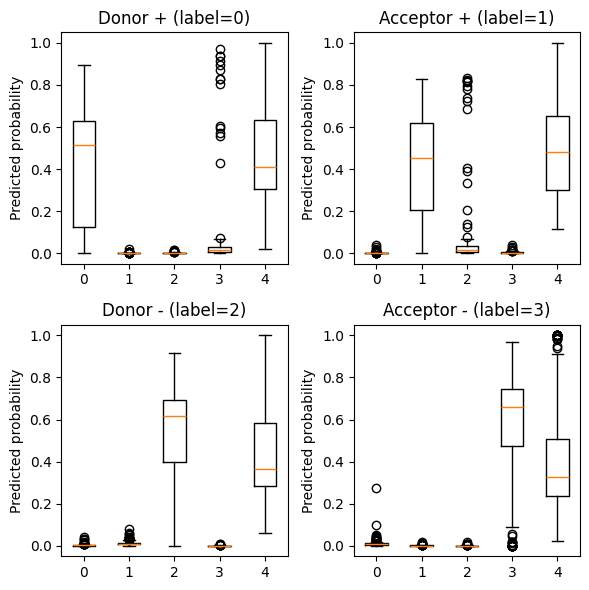

In [42]:
import matplotlib.pyplot as plt

# Plot boxplot of predicted probabilities for each class at true classes
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.title("Donor + (label=0)")
plt.boxplot([splice_df[splice_df['label'] == 0][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 2)
plt.title("Acceptor + (label=1)")
plt.boxplot([splice_df[splice_df['label'] == 1][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 3)
plt.title("Donor - (label=2)")
plt.boxplot([splice_df[splice_df['label'] == 2][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 4)
plt.title("Acceptor - (label=3)")
plt.boxplot([splice_df[splice_df['label'] == 3][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.tight_layout()
plt.show()

No samples for human in this batch.


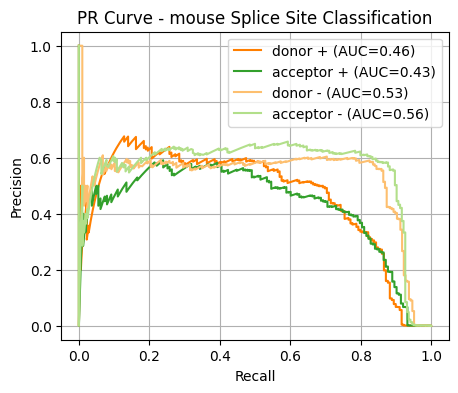

In [43]:
pr_auc_scores = {}
class_labels = {0: 'donor +', 1: 'acceptor +', 2: 'donor -', 3: 'acceptor -', 4: 'no splice site'}
class_colors = {0: '#ff7f00', 1: '#33a02c', 2:'#fdbf6f', 3: '#b2df8a', 4: '#1f78b4'}

for org in splice_logits.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    splice_logits_flat = splice_logits[org].reshape(-1, splice_logits[org].shape[-1]).detach().to('cpu').numpy()
    splice_labels_flat = splice_labels_true[org].reshape(-1).detach().to('cpu').numpy()

    from sklearn.metrics import precision_recall_curve, auc

    plt.figure(figsize=(5, 4))

    for i in range(4):
        color = class_colors[i]
        label = class_labels[i]
        
        class_idx = splice_labels_flat == i
        y_true = np.zeros_like(splice_labels_flat)
        y_true[class_idx] = 1
        y_scores = splice_logits_flat[:, i]

        if len(y_true) > 0 and y_true.sum() > 0:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = auc(recall, precision)
            pr_auc_scores[i] = pr_auc
            
            plt.plot(recall, precision, label=f"{label} (AUC={pr_auc:.2f})", color=color)
        else:
            pr_auc_scores[i] = 0.0
            print(f"  Warning: No positive samples for {label}") 

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve - {org} Splice Site Classification")
    plt.legend()
    plt.grid()
    plt.show()

### Splice usage predictions

In [44]:
# Only evaluate splice site positions (labels != 0)
splice_site_mask = splice_labels != 4  # (batch, seq_len)
donor_plus_mask = splice_labels == 0
acceptor_plus_mask = splice_labels == 1
donor_minus_mask = splice_labels == 2
acceptor_minus_mask = splice_labels == 3

if splice_site_mask.any():

    usage_true_bins_ = {}
    usage_pred_ = {}
    usage_true_ = {}

    for org in predictions:
        
        if splice_logits[org].shape[0] == 0:
            print(f"No samples for {org} in this batch.")
            continue

        print(f"\nEvaluating splice usage predictions for {org} at splice site positions:")

        # Predicted and true splice usage
        org_sse_pred = predictions[org]['splice_sites_usage'].sigmoid()
        org_sse_true = splice_usage

        # Select only splice site positions
        usage_true_at_sites = org_sse_true[splice_site_mask, :]
        usage_pred_at_sites = org_sse_pred[splice_site_mask, :]

        # Subset by organism
        usage_true_at_sites = usage_true_at_sites[:,species_conds[org]]
        usage_pred_at_sites = usage_pred_at_sites[:,range(len(species_conds[org]))]

        # Convert to numpy for evaluation
        usage_true_org = usage_true_at_sites.detach().cpu().numpy()
        usage_pred_org = usage_pred_at_sites.detach().cpu().numpy()

        # Remove rows with all zeros in true usage (not used for evaluation)
        non_zero_rows = ~np.all(usage_true_org == 0, axis=1)
        usage_true_org = usage_true_org[non_zero_rows]
        usage_pred_org = usage_pred_org[non_zero_rows]

        # Flatten for plotting
        cols = species_conds[org]  # Get columns corresponding to the condition of the organism
        usage_pred_[org] = usage_pred_org.flatten()
        usage_true_[org] = usage_true_org.flatten()

        # Group true usage in bins: 0 - 0.2 - 0.5 - 0.8 - 1.0
        usage_true_bins = np.zeros_like(usage_true_[org], dtype=int)
        usage_true_bins[usage_true_[org] < 0.2] = 0
        usage_true_bins[(usage_true_[org] >= 0.2) & (usage_true_[org] < 0.5)] = 1
        usage_true_bins[(usage_true_[org] >= 0.5) & (usage_true_[org] < 0.8)] = 2
        usage_true_bins[usage_true_[org] >= 0.8] = 3

        usage_true_bins_[org] = usage_true_bins

        # Count number of values in each bin
        for i in range(4):
            count = np.sum(usage_true_bins == i)
            print(f"True usage bin {i}: {count} values")


No samples for human in this batch.

Evaluating splice usage predictions for mouse at splice site positions:
True usage bin 0: 12614 values
True usage bin 1: 403 values
True usage bin 2: 1860 values
True usage bin 3: 17766 values


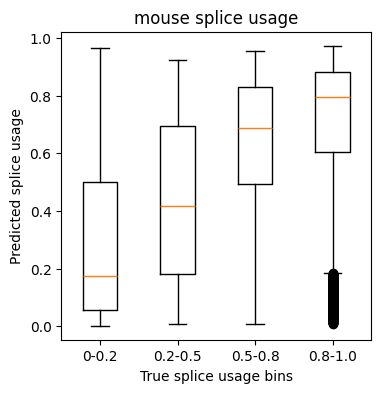

In [45]:
# Plot boxplot of predicted usage for each true usage bin
for org in usage_pred_.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    plt.figure(figsize=(4, 4))
    plt.title(f"{org} splice usage")
    plt.boxplot([usage_pred_[org][usage_true_bins_[org] == i] for i in range(4)], tick_labels=['0-0.2', '0.2-0.5', '0.5-0.8', '0.8-1.0'])
    plt.ylabel("Predicted splice usage")
    plt.xlabel("True splice usage bins")
    #plt.ylim(0, 1)
    plt.show()

Correlation between true and predicted splice usage for mouse: 0.664


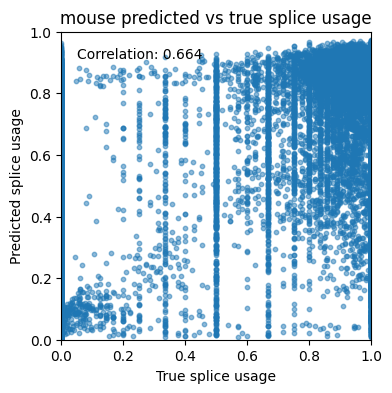

In [46]:
for org in usage_pred_.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    # Calculate correlation between true and predicted usage at splice sites
    correlation = np.corrcoef(usage_true_[org], usage_pred_[org])[0, 1]
    print(f"Correlation between true and predicted splice usage for {org}: {correlation:.3f}")

    # Plot scatter plot of predicted usage vs true usage
    plt.figure(figsize=(4, 4))
    plt.title(f"{org} predicted vs true splice usage")
    plt.scatter(usage_true_[org], usage_pred_[org], alpha=0.5, s=10)
    plt.xlabel("True splice usage")
    plt.ylabel("Predicted splice usage")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Add correlation text
    plt.text(0.05, 0.95, f"Correlation: {correlation:.3f}", transform=plt.gca().transAxes, verticalalignment='top')

    plt.show()

In [47]:
# Combine in a DataFrame: org, condition_idx, true_usage, pred_usage
data_arrays = {
    'organism': [],
    'sequence_idx': [],
    'position': [],
    'true_usage': [],
    'pred_usage': [],
    'condition_idx': [],
    'condition_name': [],
    'tissue': [],
    'timepoint': []
}

for org in predictions:
    print(f"\nBuilding dataframe for {org}:")
    
    # Get organism-specific mask
    org_mask = organism_index == species_mapping[org]
    
    # Get organism-specific predictions and true values
    org_sse_pred = predictions[org]['splice_sites_usage'].sigmoid()
    org_sse_pred = org_sse_pred[org_mask]
    org_sse_true = splice_usage[org_mask]
    
    # Get splice site positions for this organism
    org_splice_mask = splice_site_mask[org_mask]
    
    # Get sequence and position indices for splice sites
    splice_site_indices = torch.where(org_splice_mask)
    sequence_indices = splice_site_indices[0].cpu().numpy()  # Which sequence (dim 0)
    position_indices = splice_site_indices[1].cpu().numpy()  # Which position (dim 1)
    
    # Select only splice site positions
    usage_true_at_sites = org_sse_true[org_splice_mask, :]
    usage_pred_at_sites = org_sse_pred[org_splice_mask, :]
    
    # Get condition indices for this organism
    org_conds = species_conds[org]
    num_sites = usage_true_at_sites.shape[0]
    num_conds = len(org_conds)
    
    # Convert to numpy once
    true_vals = usage_true_at_sites.cpu().numpy()  # shape: (num_sites, num_total_conditions)
    pred_vals = usage_pred_at_sites.detach().cpu().numpy()  # shape: (num_sites, num_org_conditions)
    
    # Build arrays for this organism
    for cond_idx_pred, cond_idx_true in enumerate(org_conds):
        cond_name = metadata['usage_conditions'][cond_idx_true]
        tissue, timepoint = cond_name.split('_')
        data_arrays['organism'].append(np.full(num_sites, org, dtype=object))
        data_arrays['true_usage'].append(true_vals[:, cond_idx_true])
        data_arrays['pred_usage'].append(pred_vals[:, cond_idx_pred])
        data_arrays['sequence_idx'].append(sequence_indices)
        data_arrays['position'].append(position_indices)
        data_arrays['condition_idx'].append(np.full(num_sites, cond_idx_true, dtype=int))
        data_arrays['condition_name'].append(np.full(num_sites, cond_name, dtype=object))
        data_arrays['tissue'].append(np.full(num_sites, tissue, dtype=object))
        data_arrays['timepoint'].append(np.full(num_sites, timepoint, dtype=object))
    
    print(f"  Added {num_sites * num_conds} rows for {org}")

# Concatenate all arrays at once
all_data_df = pd.DataFrame({
    'organism': np.concatenate(data_arrays['organism']),
    'sequence_idx': np.concatenate(data_arrays['sequence_idx']),
    'position': np.concatenate(data_arrays['position']),
    'true_usage': np.concatenate(data_arrays['true_usage']),
    'pred_usage': np.concatenate(data_arrays['pred_usage']),
    'condition_idx': np.concatenate(data_arrays['condition_idx']),
    'condition_name': np.concatenate(data_arrays['condition_name']),
    'tissue': np.concatenate(data_arrays['tissue']),
    'timepoint': np.concatenate(data_arrays['timepoint'])
})

print(f"\nTotal rows in dataframe: {len(all_data_df)}")

# How many conditions/tissues/timepoints have true_usage > 0 for each site?
site_stats = all_data_df[all_data_df['true_usage'] > 0].groupby(['sequence_idx', 'position']).agg({
    'condition_idx': 'nunique',
    'timepoint': 'nunique',
    'tissue': 'nunique'
}).rename(columns={
    'condition_idx': 'num_conditions',
    'timepoint': 'num_timepoints',
    'tissue': 'num_tissues'
})

# Merge back to the original dataframe
all_data_df = all_data_df.merge(site_stats, on=['sequence_idx', 'position'], how='left').fillna(0)
all_data_df['num_conditions'] = all_data_df['num_conditions'].astype(int)
all_data_df['num_timepoints'] = all_data_df['num_timepoints'].astype(int)
all_data_df['num_tissues'] = all_data_df['num_tissues'].astype(int)

# Only evaluate position with usage data
all_data_df = all_data_df[all_data_df['num_conditions'] > 0]

print(f"\nTotal rows in dataframe: {len(all_data_df)}")

all_data_df


Building dataframe for human:
  Added 0 rows for human

Building dataframe for mouse:
  Added 69936 rows for mouse

Total rows in dataframe: 69936

Total rows in dataframe: 32643


,organism,sequence_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues
0,mouse,0,22892,0.0,0.036288,0,Brain_1,Brain,1,21,12,5
2,mouse,0,23625,0.0,0.032748,0,Brain_1,Brain,1,35,14,6
4,mouse,2,13210,0.0,0.693984,0,Brain_1,Brain,1,71,14,7
6,mouse,4,29851,0.0,0.570989,0,Brain_1,Brain,1,60,14,7
8,mouse,5,8505,1.0,0.634727,0,Brain_1,Brain,1,78,14,7
...,...,...,...,...,...,...,...,...,...,...,...,...
69925,mouse,62,15276,1.0,0.234320,96,Testis_14,Testis,14,32,14,5
69927,mouse,62,24269,0.0,0.187095,96,Testis_14,Testis,14,3,3,2
69929,mouse,62,26054,0.0,0.205554,96,Testis_14,Testis,14,38,14,7
69931,mouse,62,26674,0.0,0.044491,96,Testis_14,Testis,14,1,1,1


Per-condition splice usage predictions and true values.

In [48]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_sse_density(
        all_data_df: pd.DataFrame, 
        group_by: str, 
        output_dir: Path = None,
        log_fn=print
    ):
        """Plot density of predicted vs true SSE values.
        Args:
            all_data_df: DataFrame with SSE data, it should contain columns 'true_usage' and 'pred_usage' along with grouping columns
            group_by: Column name or list of column names to group by
            output_dir: Directory to save output
            log_fn: Logging function
        """
            
        log_fn("Plotting SSE density...")
        
        # Get valid positions where we have both true and predicted SSE
        valid_data = all_data_df.dropna(subset=['true_usage', 'pred_usage'])

        # Get unique combinations of grouping variables
        groups = valid_data.groupby(group_by).size().reset_index(name='count')
        num_groups = len(groups)
        
        # Determine subplot layout
        num_cols = min(3, num_groups)  # Max 3 columns
        num_rows = (num_groups + num_cols - 1) // num_cols
        
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4.8, num_rows * 4), squeeze=False)
        
        for i, (group_idx, group_row) in enumerate(groups.iterrows()):
            # Build filter for this group
            mask = pd.Series([True] * len(valid_data), index=valid_data.index)
            for col in group_by:
                mask &= (valid_data[col] == group_row[col])
            
            condition_data = valid_data[mask]
            
            # Build title from group values
            if len(group_by) == 1:
                title = f"{group_row[group_by[0]]}"
            else:
                title = ", ".join([f"{col}: {group_row[col]}" for col in group_by])
            
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
                    
            # 2D hexbin plot
            hb = ax.hexbin(
                condition_data['true_usage'],
                condition_data['pred_usage'],
                gridsize=30,
                cmap='rocket_r',
                mincnt=1
            )
            plt.colorbar(
                hb,
                ax=ax,
                label='Count',
                pad=0.2
            )
            
            # Add pearson correlation value and number of points to plot
            num_points = len(condition_data)
            if num_points >= 2:
                corr = np.corrcoef(condition_data['true_usage'], condition_data['pred_usage'])[0, 1]
                ax.text(0.05, 0.95, f"r = {corr:.2f}\nn = {num_points}", transform=ax.transAxes, fontsize=10, verticalalignment='top')    
            else:
                ax.text(0.05, 0.95, f"n = {num_points}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
                
            # Top histogram (True SSE)
            ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
            ax_histx.hist(condition_data['true_usage'], bins=30, color='gray', alpha=0.7)
            ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
            
            # Right histogram (Pred SSE)
            ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
            ax_histy.hist(condition_data['pred_usage'], bins=30, orientation='horizontal', color='gray', alpha=0.7)
            ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
            
            ax.set_xlabel('True Usage', fontsize=10)
            ax.set_ylabel('Predicted Usage', fontsize=10)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_title(title, fontsize=12)
            ax.grid()
        
        # Hide unused subplots
        for i in range(num_groups, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            axs[row, col].set_visible(False)
        
        plt.tight_layout()
        if output_dir is not None:
            density_plot = output_dir / "sse_density.png"
            plt.savefig(density_plot, dpi=150)
            plt.close()
            log_fn(f"Saved density plot to {density_plot}")
        else:
            plt.show()

Plotting SSE density...


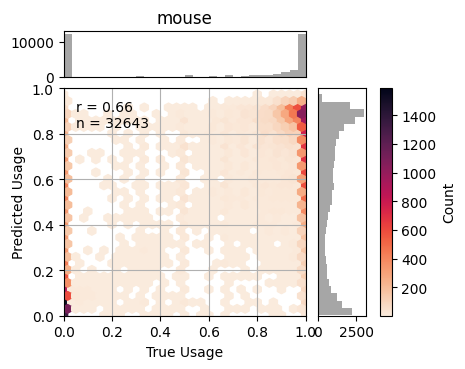

In [49]:
%matplotlib inline
plot_sse_density(
    all_data_df,
    group_by=['organism']
)

## Load all predictions

### Parse predictions data

Load genomic coord info for samples in the batches of test data

In [50]:
import os
import pandas as pd

model_dir = "/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/full_50kb/mouse_human"
preds_dir = os.path.join(model_dir, "predictions")
batch_map_fn = os.path.join(preds_dir, "batch_sample_mapping.csv")
batch_map_df = pd.read_csv(batch_map_fn)
batch_map_df

,batch_idx,sample_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,0,0,11,hum.10118,human_GRCh37,0,1,+,26405019,26353869,0
1,0,1,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
2,0,2,11,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0
3,0,3,11,hum.10118,human_GRCh37,10,10,+,26609619,26558469,0
4,0,4,11,hum.10118,human_GRCh37,14,12,+,26660769,26609619,0
...,...,...,...,...,...,...,...,...,...,...,...
3692,462,3692,4,mou.33625,mouse_GRCm38,26,26,+,156237535,156186385,1
3693,462,3693,4,mou.33627,mouse_GRCm38,1031,1031,-,156252324,156201174,1
3694,462,3694,4,mou.33628,mouse_GRCm38,473,475,+,156287221,156236071,1
3695,462,3695,4,mou.33629,mouse_GRCm38,11,8,-,156294753,156243603,1


Load splice classification predictions

In [51]:
preds_splice_fn = os.path.join(preds_dir, "splice_site_predictions_all.csv.gz")
preds_splice_df = pd.read_csv(preds_splice_fn)
preds_splice_df

,organism,dataset_sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4
0,human,1,1,6296,1,0.000255,0.726096,0.002349,0.000242,0.271058
1,human,1,1,6490,0,0.507915,0.000677,0.000385,0.001700,0.489323
2,human,1,1,8143,1,0.001175,0.452452,0.002395,0.000405,0.543574
3,human,1,1,8214,0,0.752828,0.000529,0.000221,0.002071,0.244351
4,human,1,1,27408,1,0.003784,0.523648,0.001711,0.003923,0.466935
...,...,...,...,...,...,...,...,...,...,...
45365,mouse,3696,7,22439,3,0.000209,0.000030,0.000015,0.012912,0.986834
45366,mouse,3696,7,22547,3,0.009972,0.003361,0.002432,0.319097,0.665137
45367,mouse,3696,7,28027,2,0.009865,0.007116,0.291607,0.000513,0.690899
45368,mouse,3696,7,28074,3,0.005082,0.003370,0.000457,0.157537,0.833555


Add predicted class labels based on predicted probabilities

In [52]:
preds_splice_df['pred_label'] = preds_splice_df[[f'pred_{i}' for i in range(5)]].idxmax(axis=1).str.replace('pred_', '').astype(int)
preds_splice_df

,organism,dataset_sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,pred_label
0,human,1,1,6296,1,0.000255,0.726096,0.002349,0.000242,0.271058,1
1,human,1,1,6490,0,0.507915,0.000677,0.000385,0.001700,0.489323,0
2,human,1,1,8143,1,0.001175,0.452452,0.002395,0.000405,0.543574,4
3,human,1,1,8214,0,0.752828,0.000529,0.000221,0.002071,0.244351,0
4,human,1,1,27408,1,0.003784,0.523648,0.001711,0.003923,0.466935,1
...,...,...,...,...,...,...,...,...,...,...,...
45365,mouse,3696,7,22439,3,0.000209,0.000030,0.000015,0.012912,0.986834,4
45366,mouse,3696,7,22547,3,0.009972,0.003361,0.002432,0.319097,0.665137,4
45367,mouse,3696,7,28027,2,0.009865,0.007116,0.291607,0.000513,0.690899,4
45368,mouse,3696,7,28074,3,0.005082,0.003370,0.000457,0.157537,0.833555,4


Load splice usage predictions

In [54]:
preds_usage_fn = os.path.join(preds_dir, "splice_usage_predictions_all.csv.gz")
preds_usage_df = pd.read_csv(preds_usage_fn)
preds_usage_df

,organism,dataset_sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues
0,human,1.0,1,6296,1.000,0.445270,0,Brain_1,Brain,1,16,11,6
1,human,1.0,1,8143,1.000,0.513095,0,Brain_1,Brain,1,17,11,6
2,human,1.0,1,27408,0.000,0.389336,0,Brain_1,Brain,1,10,8,5
3,human,2.0,2,21332,1.000,0.671282,0,Brain_1,Brain,1,15,9,5
4,human,2.0,2,30055,0.000,0.628221,0,Brain_1,Brain,1,13,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882501,mouse,3696.0,7,21722,0.333,0.652389,96,Testis_14,Testis,14,91,14,7
1882502,mouse,3696.0,7,22037,0.000,0.715056,96,Testis_14,Testis,14,91,14,7
1882503,mouse,3696.0,7,22332,0.333,0.697586,96,Testis_14,Testis,14,92,14,7
1882504,mouse,3696.0,7,28027,0.600,0.564531,96,Testis_14,Testis,14,93,14,7


In [55]:
# dataset_sample_idx should be integer and renamed to sample_idx in both dataframes for merging
preds_splice_df['dataset_sample_idx'] = preds_splice_df['dataset_sample_idx'].astype(int)
preds_usage_df['dataset_sample_idx'] = preds_usage_df['dataset_sample_idx'].astype(int)
preds_splice_df.rename(columns={'dataset_sample_idx': 'sample_idx'}, inplace=True)
preds_usage_df.rename(columns={'dataset_sample_idx': 'sample_idx'}, inplace=True)

# site column should be sample_idx_position
preds_splice_df['site'] = preds_splice_df['sample_idx'].astype(str) + "_" + preds_splice_df['position'].astype(str)
preds_usage_df['site'] = preds_usage_df['sample_idx'].astype(str) + "_" + preds_usage_df['position'].astype(str)

Combine predictions in a DataFrame for plotting.

In [56]:
# Ensure all key columns match types
key_cols = ["organism", "sample_idx", "batch_sample_idx", "position", "site"]
for col in key_cols:
    preds_usage_df[col] = preds_usage_df[col].astype(preds_splice_df[col].dtype)

# Merge
merged_df = preds_usage_df.merge(
    preds_splice_df[["organism", "sample_idx", "batch_sample_idx", "position", "site", "label", "pred_label"]],
    on=key_cols,
    how="left",
    copy=False,
    sort=False
)

Calculate pre-site correlation between predicted and true usage values across timepoints and tissues.

In [57]:
key_cols = ["organism", "sample_idx", "batch_sample_idx", "position", "site"]

def corr_func(x):
    return x["true_usage"].corr(x["pred_usage"])

site_corr = (
    merged_df
    .groupby(key_cols, sort=False)[["true_usage", "pred_usage"]]
    .corr()
    .unstack()
    .iloc[:, 1]
    .reset_index(name="site_correlation")
)

merged_df = merged_df.merge(site_corr, on=key_cols, how="left")


Add genomic coordinates to the predictions.

In [58]:
merged_ann_df = merged_df.merge(
    batch_map_df,
    on="sample_idx",
    how="left",
    copy=False,
    sort=False
)
merged_ann_df

,organism,sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,...,batch_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,human,1,1,6296,1.000,0.445270,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
1,human,1,1,8143,1.000,0.513095,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
2,human,1,1,27408,0.000,0.389336,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
3,human,2,2,21332,1.000,0.671282,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0
4,human,2,2,30055,0.000,0.628221,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882501,mouse,3696,7,21722,0.333,0.652389,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
1882502,mouse,3696,7,22037,0.000,0.715056,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
1882503,mouse,3696,7,22332,0.333,0.697586,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
1882504,mouse,3696,7,28027,0.600,0.564531,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1


In [59]:
# Order columns
final_df = merged_ann_df[[
    "organism", "species_id", "sample_idx", "batch_idx", "batch_sample_idx", "genome_id", "gene_id", 
    "chromosome", "window_start", "window_end", "position", "strand", "site", 
    "label", "pred_label", "true_usage", "pred_usage",
    "condition_idx", "condition_name", "tissue", "timepoint", 
    "num_conditions", "num_timepoints", "num_tissues", "site_correlation"
]]
final_df

,organism,species_id,sample_idx,batch_idx,batch_sample_idx,genome_id,gene_id,chromosome,window_start,window_end,...,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site_correlation
0,human,0,1,0,1,human_GRCh37,hum.10118,11,26456169,26507319,...,1.000,0.445270,0,Brain_1,Brain,1,16,11,6,0.432751
1,human,0,1,0,1,human_GRCh37,hum.10118,11,26456169,26507319,...,1.000,0.513095,0,Brain_1,Brain,1,17,11,6,0.523030
2,human,0,1,0,1,human_GRCh37,hum.10118,11,26456169,26507319,...,0.000,0.389336,0,Brain_1,Brain,1,10,8,5,0.405583
3,human,0,2,0,2,human_GRCh37,hum.10118,11,26507319,26558469,...,1.000,0.671282,0,Brain_1,Brain,1,15,9,5,0.465741
4,human,0,2,0,2,human_GRCh37,hum.10118,11,26507319,26558469,...,0.000,0.628221,0,Brain_1,Brain,1,13,8,6,0.409155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882501,mouse,1,3696,462,7,mouse_GRCm38,mou.33620,4,156156061,156207211,...,0.333,0.652389,96,Testis_14,Testis,14,91,14,7,0.210174
1882502,mouse,1,3696,462,7,mouse_GRCm38,mou.33620,4,156156061,156207211,...,0.000,0.715056,96,Testis_14,Testis,14,91,14,7,0.676126
1882503,mouse,1,3696,462,7,mouse_GRCm38,mou.33620,4,156156061,156207211,...,0.333,0.697586,96,Testis_14,Testis,14,92,14,7,0.437449
1882504,mouse,1,3696,462,7,mouse_GRCm38,mou.33620,4,156156061,156207211,...,0.600,0.564531,96,Testis_14,Testis,14,93,14,7,0.420435


In [60]:
final_df.to_csv(os.path.join(preds_dir, "merged_predictions.csv.gz"), index=False, compression="gzip")

### Evaluate prediction accuracy by context length

In [61]:
genome_dir = "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf"

human_bed_fn = "/home/elek/sds/sd17d003/Anamaria/borzoi_folds/Homo_sapiens.transcripts.bed"
human_bed = pd.read_csv(human_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])
mouse_bed_fn = "/home/elek/sds/sd17d003/Anamaria/borzoi_folds/Mus_musculus.transcripts.bed"
mouse_bed = pd.read_csv(mouse_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])

# Get gene coords from min start and max end of transcripts
human_bed['gene_start'] = human_bed.groupby('gene_id')['start'].transform('min')
human_bed['gene_end'] = human_bed.groupby('gene_id')['end'].transform('max')
human_genes_bed = human_bed[['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand']].drop_duplicates()
human_genes_bed['gene_length'] = human_genes_bed['gene_end'] - human_genes_bed['gene_start']
print(human_genes_bed.head())

mouse_bed['gene_start'] = mouse_bed.groupby('gene_id')['start'].transform('min')
mouse_bed['gene_end'] = mouse_bed.groupby('gene_id')['end'].transform('max')
mouse_genes_bed = mouse_bed[['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand']].drop_duplicates()
mouse_genes_bed['gene_length'] = mouse_genes_bed['gene_end'] - mouse_genes_bed['gene_start']
print(mouse_genes_bed.head())

genes_bed = pd.concat([human_genes_bed, mouse_genes_bed], ignore_index=True)

/tmp/ipykernel_825389/2934907467.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  human_bed = pd.read_csv(human_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])
/tmp/ipykernel_825389/2934907467.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  mouse_bed = pd.read_csv(mouse_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])


    chrom  gene_start  gene_end gene_id strand  gene_length
0       1       11609     14412   hum.1      +         2803
1       1       14332     30082   hum.2      -        15750
155     1     1834378   1835146   hum.3      -          768
156     1     1837440   1837658   hum.4      -          218
157     1     1845278   1845643   hum.5      +          365
  chrom  gene_start  gene_end gene_id strand  gene_length
0     1     3057716   3057999   mou.1      +          283
1     1     3151275   3151544   mou.2      +          269
2     1     3152096   3154131   mou.3      +         2035
3     1     3986251   3986486   mou.4      -          235
4     1     3873266   3908576   mou.5      +        35310


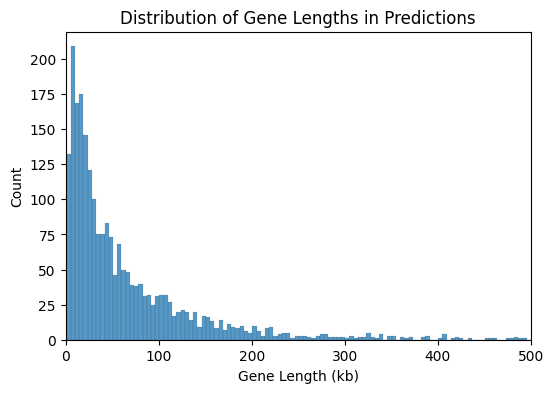

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot distribution of gene lengths
plt.figure(figsize=(6, 4))
sns.histplot(genes_bed[genes_bed['gene_id'].isin(final_df['gene_id'])]['gene_length']/1000, bins=500)
plt.title("Distribution of Gene Lengths in Predictions")
plt.xlabel("Gene Length (kb)")
plt.ylabel("Count")
plt.xlim(0, 500)
plt.show()

#### Splice site prediction

In [63]:
preds_splice_ann = preds_splice_df.merge(
    batch_map_df,
    on="sample_idx",
    how="left",
    copy=False,
    sort=False
)
preds_splice_ann

,organism,sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,...,batch_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,human,1,1,6296,1,0.000255,0.726096,0.002349,0.000242,0.271058,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
1,human,1,1,6490,0,0.507915,0.000677,0.000385,0.001700,0.489323,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
2,human,1,1,8143,1,0.001175,0.452452,0.002395,0.000405,0.543574,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
3,human,1,1,8214,0,0.752828,0.000529,0.000221,0.002071,0.244351,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
4,human,1,1,27408,1,0.003784,0.523648,0.001711,0.003923,0.466935,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45365,mouse,3696,7,22439,3,0.000209,0.000030,0.000015,0.012912,0.986834,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
45366,mouse,3696,7,22547,3,0.009972,0.003361,0.002432,0.319097,0.665137,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
45367,mouse,3696,7,28027,2,0.009865,0.007116,0.291607,0.000513,0.690899,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
45368,mouse,3696,7,28074,3,0.005082,0.003370,0.000457,0.157537,0.833555,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1


In [64]:
# add gene length to predictions
preds_splice_ann_df = preds_splice_ann.merge(
    genes_bed[['gene_id', 'gene_length']],
    on='gene_id',
    how='left'
)
preds_splice_ann_df

,organism,sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,...,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id,gene_length
0,human,1,1,6296,1,0.000255,0.726096,0.002349,0.000242,0.271058,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
1,human,1,1,6490,0,0.507915,0.000677,0.000385,0.001700,0.489323,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
2,human,1,1,8143,1,0.001175,0.452452,0.002395,0.000405,0.543574,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
3,human,1,1,8214,0,0.752828,0.000529,0.000221,0.002071,0.244351,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
4,human,1,1,27408,1,0.003784,0.523648,0.001711,0.003923,0.466935,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45365,mouse,3696,7,22439,3,0.000209,0.000030,0.000015,0.012912,0.986834,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204
45366,mouse,3696,7,22547,3,0.009972,0.003361,0.002432,0.319097,0.665137,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204
45367,mouse,3696,7,28027,2,0.009865,0.007116,0.291607,0.000513,0.690899,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204
45368,mouse,3696,7,28074,3,0.005082,0.003370,0.000457,0.157537,0.833555,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204


In [65]:
# calculate accuracy of splice site classification for each gene
preds_splice_ann_df['splice_site_correct'] = preds_splice_ann_df['label'] == preds_splice_ann_df['pred_label']
gene_acc = preds_splice_ann_df.groupby('gene_id')['splice_site_correct'].mean().reset_index(name='splice_site_accuracy')
preds_splice_ann_df = preds_splice_ann_df.merge(
    gene_acc,
    on='gene_id',
    how='left'
)
preds_splice_ann_df

,organism,sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,...,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id,gene_length,splice_site_correct,splice_site_accuracy
0,human,1,1,6296,1,0.000255,0.726096,0.002349,0.000242,0.271058,...,human_GRCh37,3,4,+,26507319,26456169,0,331213,True,0.625000
1,human,1,1,6490,0,0.507915,0.000677,0.000385,0.001700,0.489323,...,human_GRCh37,3,4,+,26507319,26456169,0,331213,True,0.625000
2,human,1,1,8143,1,0.001175,0.452452,0.002395,0.000405,0.543574,...,human_GRCh37,3,4,+,26507319,26456169,0,331213,False,0.625000
3,human,1,1,8214,0,0.752828,0.000529,0.000221,0.002071,0.244351,...,human_GRCh37,3,4,+,26507319,26456169,0,331213,True,0.625000
4,human,1,1,27408,1,0.003784,0.523648,0.001711,0.003923,0.466935,...,human_GRCh37,3,4,+,26507319,26456169,0,331213,True,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45365,mouse,3696,7,22439,3,0.000209,0.000030,0.000015,0.012912,0.986834,...,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,False,0.402439
45366,mouse,3696,7,22547,3,0.009972,0.003361,0.002432,0.319097,0.665137,...,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,False,0.402439
45367,mouse,3696,7,28027,2,0.009865,0.007116,0.291607,0.000513,0.690899,...,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,False,0.402439
45368,mouse,3696,7,28074,3,0.005082,0.003370,0.000457,0.157537,0.833555,...,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,False,0.402439


/tmp/ipykernel_825389/842934002.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = preds_splice_ann_df.groupby('gene_length_bin')['gene_id'].nunique()


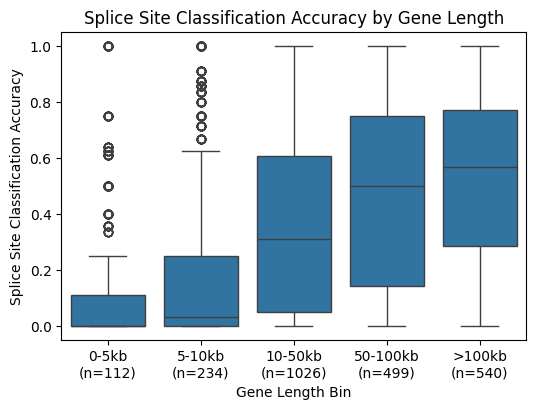

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#plot accuracy boxplots per gene binned by gene length
preds_splice_ann_df['gene_length_bin'] = pd.cut(preds_splice_ann_df['gene_length'], bins=[0, 5e3, 10e3, 50e3, 100e3, np.inf], labels=['0-5kb', '5-10kb', '10-50kb', '50-100kb', '>100kb'])
plt.figure(figsize=(6, 4))
sns.boxplot(x='gene_length_bin', y='splice_site_accuracy', data=preds_splice_ann_df)
plt.xlabel('Gene Length Bin')
plt.ylabel('Splice Site Classification Accuracy')
plt.title('Splice Site Classification Accuracy by Gene Length')
plt.ylim(-0.05, 1.05)
#add n=number of genes in each bin to x-axis labels
bin_counts = preds_splice_ann_df.groupby('gene_length_bin')['gene_id'].nunique()
new_labels = [f"{bin}\n(n={bin_counts[bin]})" for bin in preds_splice_ann_df['gene_length_bin'].cat.categories]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
plt.show()

/tmp/ipykernel_825389/1797871693.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = preds_splice_ann_df.groupby('position_bin')['gene_id'].nunique()


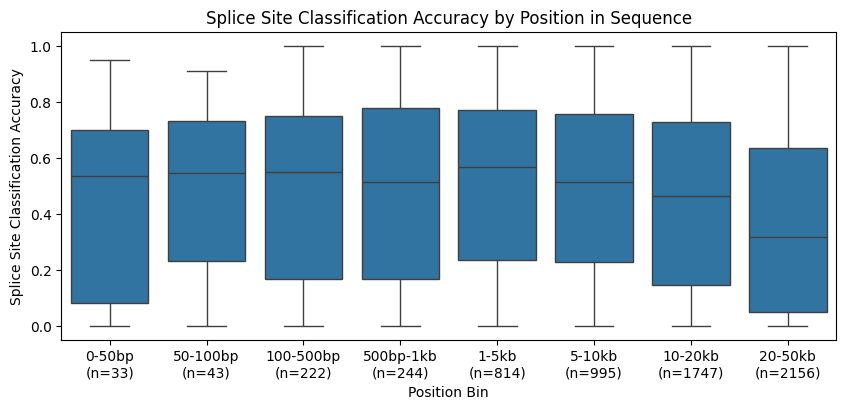

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot accuracy boxplots per gene binned by position in the sequence
preds_splice_ann_df['position_bin'] = pd.cut(preds_splice_ann_df['position'], bins=[0, 50, 1e2, 5e2, 1e3, 5e3, 10e3, 20e3, 50e3], labels=['0-50bp', '50-100bp', '100-500bp', '500bp-1kb', '1-5kb', '5-10kb', '10-20kb', '20-50kb'])
plt.figure(figsize=(10, 4))
sns.boxplot(x='position_bin', y='splice_site_accuracy', data=preds_splice_ann_df)
plt.xlabel('Position Bin')
plt.ylabel('Splice Site Classification Accuracy')
plt.title('Splice Site Classification Accuracy by Position in Sequence')
#add n=number of genes in each bin to x-axis labels
bin_counts = preds_splice_ann_df.groupby('position_bin')['gene_id'].nunique()
new_labels = [f"{bin}\n(n={bin_counts[bin]})" for bin in preds_splice_ann_df['position_bin'].cat.categories]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
plt.show()

#### Splice usage prediction

In [68]:
preds_usage_ann = preds_usage_df.merge(
    batch_map_df,
    on="sample_idx",
    how="left",
    copy=False,
    sort=False
)
preds_usage_ann

,organism,sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,...,batch_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,human,1,1,6296,1.000,0.445270,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
1,human,1,1,8143,1.000,0.513095,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
2,human,1,1,27408,0.000,0.389336,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0
3,human,2,2,21332,1.000,0.671282,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0
4,human,2,2,30055,0.000,0.628221,0,Brain_1,Brain,1,...,0,11,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882501,mouse,3696,7,21722,0.333,0.652389,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
1882502,mouse,3696,7,22037,0.000,0.715056,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
1882503,mouse,3696,7,22332,0.333,0.697586,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1
1882504,mouse,3696,7,28027,0.600,0.564531,96,Testis_14,Testis,14,...,462,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1


In [69]:
# add gene length to predictions
preds_usage_ann_df = preds_usage_ann.merge(
    genes_bed[['gene_id', 'gene_length']],
    on='gene_id',
    how='left'
)
preds_usage_ann_df

,organism,sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,...,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id,gene_length
0,human,1,1,6296,1.000,0.445270,0,Brain_1,Brain,1,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
1,human,1,1,8143,1.000,0.513095,0,Brain_1,Brain,1,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
2,human,1,1,27408,0.000,0.389336,0,Brain_1,Brain,1,...,11,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213
3,human,2,2,21332,1.000,0.671282,0,Brain_1,Brain,1,...,11,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0,331213
4,human,2,2,30055,0.000,0.628221,0,Brain_1,Brain,1,...,11,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0,331213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882501,mouse,3696,7,21722,0.333,0.652389,96,Testis_14,Testis,14,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204
1882502,mouse,3696,7,22037,0.000,0.715056,96,Testis_14,Testis,14,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204
1882503,mouse,3696,7,22332,0.333,0.697586,96,Testis_14,Testis,14,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204
1882504,mouse,3696,7,28027,0.600,0.564531,96,Testis_14,Testis,14,...,4,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204


In [70]:
# Calculate correlation for each gene and map back to all rows
gene_corr = preds_usage_ann_df.groupby('gene_id').apply(
    lambda df: df['true_usage'].corr(df['pred_usage'])
)
preds_usage_ann_df['usage_correlation'] = preds_usage_ann_df['gene_id'].map(gene_corr)
preds_usage_ann_df

/tmp/ipykernel_825389/3719162353.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gene_corr = preds_usage_ann_df.groupby('gene_id').apply(


,organism,sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,...,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id,gene_length,usage_correlation
0,human,1,1,6296,1.000,0.445270,0,Brain_1,Brain,1,...,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213,0.264870
1,human,1,1,8143,1.000,0.513095,0,Brain_1,Brain,1,...,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213,0.264870
2,human,1,1,27408,0.000,0.389336,0,Brain_1,Brain,1,...,hum.10118,human_GRCh37,3,4,+,26507319,26456169,0,331213,0.264870
3,human,2,2,21332,1.000,0.671282,0,Brain_1,Brain,1,...,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0,331213,0.264870
4,human,2,2,30055,0.000,0.628221,0,Brain_1,Brain,1,...,hum.10118,human_GRCh37,10,10,+,26558469,26507319,0,331213,0.264870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882501,mouse,3696,7,21722,0.333,0.652389,96,Testis_14,Testis,14,...,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,0.923029
1882502,mouse,3696,7,22037,0.000,0.715056,96,Testis_14,Testis,14,...,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,0.923029
1882503,mouse,3696,7,22332,0.333,0.697586,96,Testis_14,Testis,14,...,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,0.923029
1882504,mouse,3696,7,28027,0.600,0.564531,96,Testis_14,Testis,14,...,mou.33620,mouse_GRCm38,2739,2739,-,156207211,156156061,1,34204,0.923029


/tmp/ipykernel_825389/252338842.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = preds_usage_ann_df.groupby('gene_length_bin')['gene_id'].nunique()


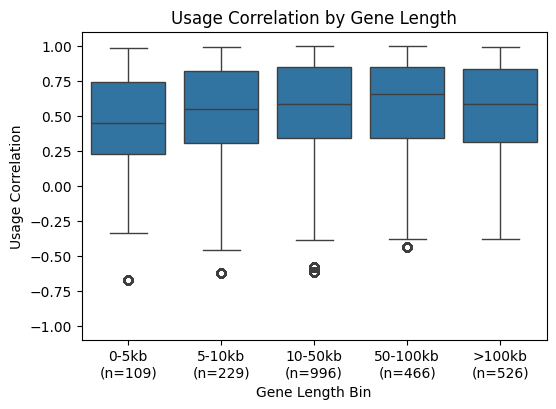

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#plot correlation boxplots per gene binned by gene length
preds_usage_ann_df['gene_length_bin'] = pd.cut(preds_usage_ann_df['gene_length'], bins=[0, 5e3, 10e3, 50e3, 100e3, np.inf], labels=['0-5kb', '5-10kb', '10-50kb', '50-100kb', '>100kb'])
plt.figure(figsize=(6, 4))
sns.boxplot(x='gene_length_bin', y='usage_correlation', data=preds_usage_ann_df)
plt.xlabel('Gene Length Bin')
plt.ylabel('Usage Correlation')
plt.title('Usage Correlation by Gene Length')
plt.ylim(-1.1, 1.1)
#add n=number of genes in each bin to x-axis labels
bin_counts = preds_usage_ann_df.groupby('gene_length_bin')['gene_id'].nunique()
new_labels = [f"{bin}\n(n={bin_counts[bin]})" for bin in preds_usage_ann_df['gene_length_bin'].cat.categories]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
plt.show()

/tmp/ipykernel_825389/2873344836.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = preds_usage_ann_df.groupby('position_bin')['gene_id'].nunique()


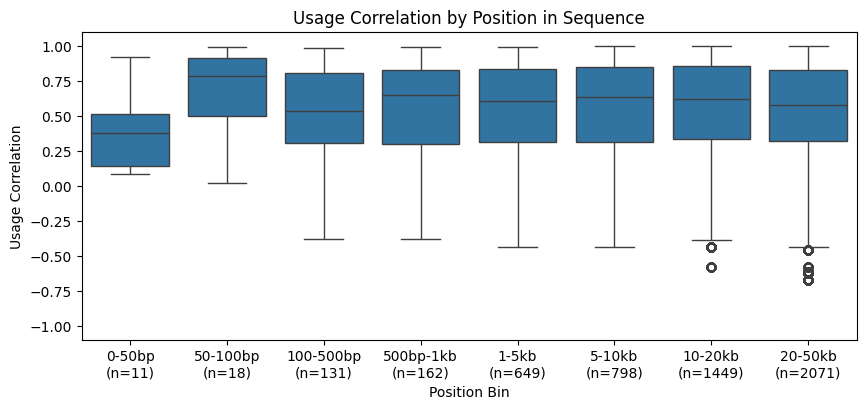

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot accuracy boxplots per gene binned by position in the sequence
preds_usage_ann_df['position_bin'] = pd.cut(preds_usage_ann_df['position'], bins=[0, 50, 1e2, 5e2, 1e3, 5e3, 10e3, 20e3, 50e3], labels=['0-50bp', '50-100bp', '100-500bp', '500bp-1kb', '1-5kb', '5-10kb', '10-20kb', '20-50kb'])
plt.figure(figsize=(10, 4))
sns.boxplot(x='position_bin', y='usage_correlation', data=preds_usage_ann_df)
plt.xlabel('Position Bin')
plt.ylabel('Usage Correlation')
plt.title('Usage Correlation by Position in Sequence')
plt.ylim(-1.1, 1.1)
#add n=number of genes in each bin to x-axis labels
bin_counts = preds_usage_ann_df.groupby('position_bin')['gene_id'].nunique()
new_labels = [f"{bin}\n(n={bin_counts[bin]})" for bin in preds_usage_ann_df['position_bin'].cat.categories]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)
plt.show()

### Correlations

In [25]:
final_df = pd.read_csv(os.path.join(model_dir, "predictions", "merged_predictions.csv.gz"), compression="gzip")
final_df

,organism,species_id,sample_idx,batch_idx,batch_sample_idx,genome_id,gene_id,chromosome,window_start,window_end,...,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site_correlation
0,human,0,1,0,1,human_GRCh37,hum.10118,11,26456169,26507319,...,0.0,0.463184,0,Brain_10,Brain,10,7,5,5,0.656000
1,human,0,1,0,1,human_GRCh37,hum.10118,11,26456169,26507319,...,1.0,0.368629,0,Brain_10,Brain,10,6,4,3,0.637168
2,human,0,1,0,1,human_GRCh37,hum.10118,11,26456169,26507319,...,0.0,0.514252,0,Brain_10,Brain,10,3,3,2,0.487556
3,human,0,2,0,2,human_GRCh37,hum.10118,11,26507319,26558469,...,1.0,0.558833,0,Brain_10,Brain,10,6,3,3,0.877494
4,human,0,2,0,2,human_GRCh37,hum.10118,11,26507319,26558469,...,0.0,0.352175,0,Brain_10,Brain,10,2,1,2,0.544303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699673,mouse,1,3678,229,15,mouse_GRCm38,mou.33620,4,156166058,156217208,...,0.6,0.384135,36,Testis_14,Testis,14,34,5,7,0.459860
699674,mouse,1,3678,229,15,mouse_GRCm38,mou.33620,4,156166058,156217208,...,0.0,0.061095,36,Testis_14,Testis,14,25,5,6,0.825830
699675,mouse,1,3678,229,15,mouse_GRCm38,mou.33620,4,156166058,156217208,...,0.6,0.674255,36,Testis_14,Testis,14,34,5,7,0.214803
699676,mouse,1,3678,229,15,mouse_GRCm38,mou.33620,4,156166058,156217208,...,0.0,0.060462,36,Testis_14,Testis,14,6,3,4,-0.227064


Plot  histogram of site correlations per species (columns) and tissues (rows).

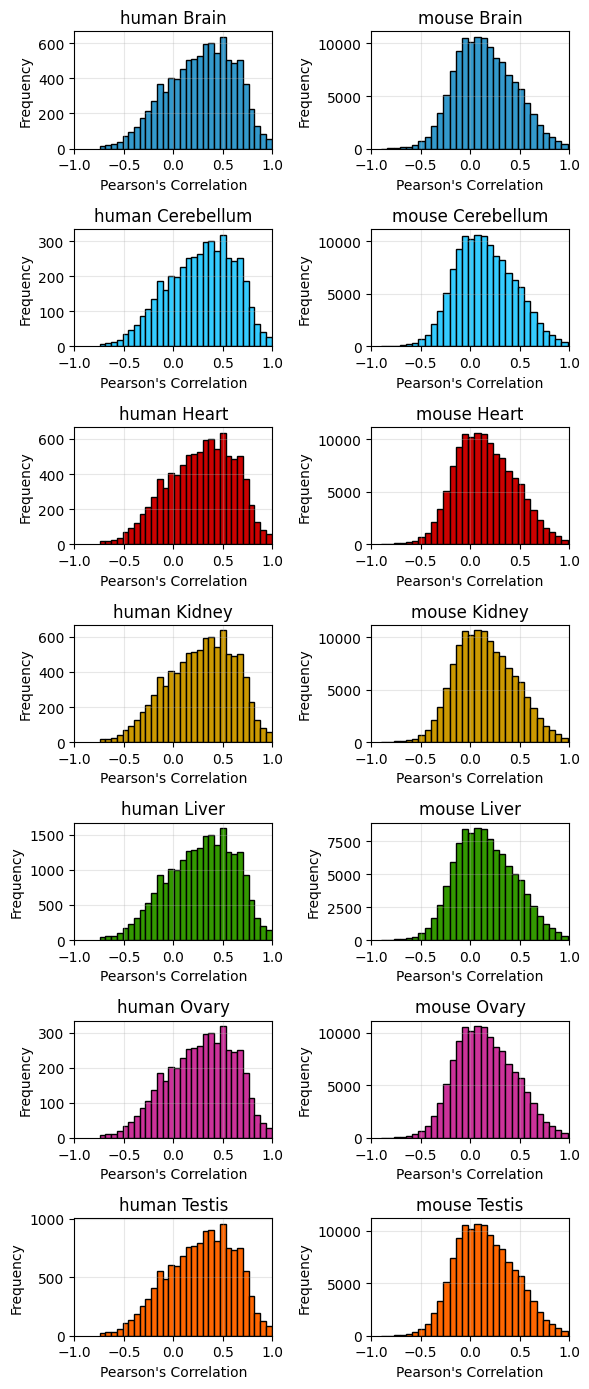

In [42]:
# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

# Plot  histogram of site correlations per species (columns) and tissues (rows)
unique_tissues = final_df['tissue'].unique()
num_rows = len(unique_tissues)
unique_species = final_df['organism'].unique()
num_cols = len(unique_species)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2), squeeze=False)
for col, species in enumerate(unique_species):
    for row, tissue in enumerate(unique_tissues):
        ax = axs[row, col]
        tissue_corrs = final_df[(final_df['tissue'] == tissue) & (final_df['organism'] == species)]['site_correlation'].dropna()
        tissue_color = tissue_colors.get(tissue, '#000000')
        ax.hist(tissue_corrs, bins=30, color=tissue_color, edgecolor='black')
        ax.set_title(f'{species} {tissue}', fontsize=12)
        ax.set_xlabel("Pearson's Correlation", fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_xlim(-1, 1)
        ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Function to plot splice site usage across timepoints, per tissue

In [43]:
def plot_sse_timeseries(plot_df, tissue_colors, output_path=None, smooth=False, highlight_threshold=0.9, highlight_sites=None, title=None, show_legend=True):
    """
    Plot SSE timeseries for multiple splice sites and tissues.
    
    Args:
        plot_df: DataFrame with columns: site, tissue, timepoint, true_usage, pred_usage
        tissue_colors: Dictionary mapping tissue names to colors
        output_path: Path to save the figure (optional)
        smooth: Whether to apply spline smoothing to lines
        highlight_threshold: Correlation threshold for highlighting (default 0.9). Set to None to disable correlation-based highlighting.
        title: Optional title for the entire figure
        show_legend: Whether to show the legend (default True)
        highlight_sites: Dictionary mapping site names to list of tissues to highlight, e.g., {'site1': ['tissue1', 'tissue2']} or set to 'all' to highlight all tissues for that site
    
    Returns:
        matplotlib figure
    """
    unique_sites = plot_df['site'].unique()
    
    timepoint_order = sorted(plot_df['timepoint'].unique())
    plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)
    
    n_sites = len(unique_sites)
    unique_tissues_plot = plot_df['tissue'].unique()
    n_tissues = len(unique_tissues_plot)
    fig, axes = plt.subplots(n_tissues, n_sites, figsize=(2.5 * n_sites, 2.5 * n_tissues), sharex='col')
    
    # Add figure title if provided
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    if n_sites == 1 and n_tissues == 1:
        axes = axes.reshape(1, 1)
    elif n_sites == 1:
        axes = axes.reshape(n_tissues, 1)
    elif n_tissues == 1:
        axes = axes.reshape(1, n_sites)
    
    legend_handles, legend_labels = [], []
    for col_idx, site in enumerate(unique_sites):
        site_data = plot_df[plot_df['site'] == site]
        for tissue in site_data['tissue'].unique():
            row_idx = list(unique_tissues_plot).index(tissue)
            tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
            color = tissue_colors.get(tissue, '#000000')
            x_values = tissue_data['timepoint'].cat.codes
            y_sse_true = tissue_data['true_usage'].values
            y_sse_pred = tissue_data['pred_usage'].values
            
            # Calculate correlation only if we have at least 2 data points
            if len(y_sse_true) >= 2:
                correlation = np.corrcoef(y_sse_true, y_sse_pred)[0, 1]
            else:
                correlation = np.nan
    
            def smooth_spline(x, y):
                if smooth and len(x) > 3:
                    x_dense = np.linspace(x.min(), x.max(), 100)
                    if len(np.unique(x)) < 4:
                        return x, y
                    from scipy.interpolate import make_interp_spline
                    spline = make_interp_spline(x, y, k=2)
                    y_smooth = spline(x_dense)
                    return x_dense, y_smooth
                else:
                    return x, y
    
            # True SSE: solid line
            x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
            line_true, = axes[row_idx, col_idx].plot(x_sse, y_sse_true_smooth, label=f'{tissue} True', color=color, linewidth=2, linestyle='-')
            axes[row_idx, col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)
    
            # Predicted SSE: dashed line
            x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
            line_pred, = axes[row_idx, col_idx].plot(x_sse, y_sse_pred_smooth, label=f'{tissue} Pred', color=color, linewidth=2, linestyle='--')
            axes[row_idx, col_idx].scatter(x_values, y_sse_pred, color=color, marker='x', s=36)
    
            if col_idx == 0:
                legend_handles.extend([line_true, line_pred])
                legend_labels.extend([f'{tissue} True', f'{tissue} Pred'])
    
            axes[row_idx, col_idx].set_ylim(0, 1)
            
            # Determine if this site-tissue combination should be highlighted
            should_highlight = False
            
            # Check correlation-based highlighting
            if highlight_threshold is not None and not np.isnan(correlation) and correlation > highlight_threshold:
                should_highlight = True
            
            # Check site-specific highlighting
            if highlight_sites is not None and site in highlight_sites:
                tissues_to_highlight = highlight_sites[site]
                if tissues_to_highlight == 'all' or tissue in tissues_to_highlight:
                    should_highlight = True
            
            # Apply highlighting
            if should_highlight:
                axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14, fontweight='bold', 
                                                 bbox=dict(boxstyle='round', facecolor='gold', alpha=0.3))
                axes[row_idx, col_idx].patch.set_edgecolor('gold')
                axes[row_idx, col_idx].patch.set_linewidth(3)
            else:
                axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14)
                
            axes[row_idx, col_idx].set_xticks(range(len(timepoint_order)))
            axes[row_idx, col_idx].set_xticklabels(timepoint_order, rotation=90)
            axes[row_idx, col_idx].grid(True, alpha=0.3)
    
    # Set y labels for first column
    for row_idx in range(n_tissues):
        axes[row_idx, 0].set_ylabel('SSE', fontsize=12, fontweight='bold')
    
    # Set x labels and rotated tick labels for last row
    for col_idx in range(n_sites):
        axes[-1, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
        axes[-1, col_idx].set_xticklabels(timepoint_order, rotation=90)
    
    if show_legend:
        fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
                   title='Tissue', title_fontsize=14, fontsize=12, ncol=1)
    
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
    
    return fig

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}


In [44]:
# Select top correlated sites to show
top_examples = final_df.sort_values(by='site_correlation', ascending=False)
top_examples = top_examples[(top_examples['num_timepoints'] >= 5) & (top_examples['num_tissues'] >= 3)]
top_examples = top_examples['site'].drop_duplicates().head(10)

In [45]:
plot_df = final_df[final_df['site'].isin(top_examples)].copy()
plot_df

,organism,species_id,sample_idx,batch_idx,batch_sample_idx,genome_id,gene_id,chromosome,window_start,window_end,...,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site_correlation
65431,human,0,1741,108,13,human_GRCh37,hum.66725,9,131366176,131376416,...,0.939,0.646554,0,Brain_10,Brain,10,16,5,7,0.941617
65497,human,0,1741,108,13,human_GRCh37,hum.66725,9,131366176,131376416,...,0.926,0.581440,4,Brain_14,Brain,14,16,5,7,0.941617
65563,human,0,1741,108,13,human_GRCh37,hum.66725,9,131366176,131376416,...,0.857,0.543535,10,Cerebellum_15,Cerebellum,15,16,5,7,0.941617
65629,human,0,1741,108,13,human_GRCh37,hum.66725,9,131366176,131376416,...,0.649,0.489177,11,Heart_10,Heart,10,16,5,7,0.941617
65695,human,0,1741,108,13,human_GRCh37,hum.66725,9,131366176,131376416,...,0.594,0.359148,13,Heart_12,Heart,12,16,5,7,0.941617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962684,mouse,1,10266,641,13,mouse_GRCm38,mou.33620,4,156166058,156176298,...,0.100,0.334966,32,Testis_10,Testis,10,30,5,7,0.946996
962787,mouse,1,10266,641,13,mouse_GRCm38,mou.33620,4,156166058,156176298,...,0.023,0.299599,33,Testis_11,Testis,11,30,5,7,0.946996
962890,mouse,1,10266,641,13,mouse_GRCm38,mou.33620,4,156166058,156176298,...,0.000,0.346862,34,Testis_12,Testis,12,30,5,7,0.946996
962993,mouse,1,10266,641,13,mouse_GRCm38,mou.33620,4,156166058,156176298,...,0.000,0.309436,35,Testis_13,Testis,13,30,5,7,0.946996


In [ ]:
plot_sse_timeseries(plot_df, tissue_colors)

### Timecourse dynamics

In [89]:
final_df = pd.read_csv(os.path.join(model_dir, "predictions", "merged_predictions.csv.gz"), compression="gzip")
final_df

,organism,species_id,sample_idx,batch_idx,batch_sample_idx,genome_id,gene_id,chromosome,window_start,window_end,...,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site_correlation
0,human,0,1,0,1,human_GRCh37,hum.10118,11,26353869,26363869,...,0.000,0.532887,0,Brain_10,Brain,10,7,5,5,0.720610
1,human,0,1,0,1,human_GRCh37,hum.10118,11,26353869,26363869,...,1.000,0.598788,0,Brain_10,Brain,10,6,4,3,0.695021
2,human,0,1,0,1,human_GRCh37,hum.10118,11,26353869,26363869,...,0.000,0.568621,0,Brain_10,Brain,10,3,3,2,0.564227
3,human,0,2,0,2,human_GRCh37,hum.10118,11,26453869,26463869,...,1.000,0.624229,0,Brain_10,Brain,10,6,3,3,0.860284
4,human,0,3,0,3,human_GRCh37,hum.10118,11,26463869,26473869,...,1.000,0.509882,0,Brain_10,Brain,10,5,3,3,0.776435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999163,mouse,1,9921,155,4,mouse_GRCm38,mou.33620,4,156176058,156186058,...,0.333,0.610169,36,Testis_14,Testis,14,33,5,7,0.148302
999164,mouse,1,9921,155,4,mouse_GRCm38,mou.33620,4,156176058,156186058,...,0.600,0.579669,36,Testis_14,Testis,14,34,5,7,0.358225
999165,mouse,1,9921,155,4,mouse_GRCm38,mou.33620,4,156176058,156186058,...,0.000,0.516082,36,Testis_14,Testis,14,25,5,6,0.199701
999166,mouse,1,9922,155,5,mouse_GRCm38,mou.33620,4,156186058,156196058,...,0.600,0.592504,36,Testis_14,Testis,14,34,5,7,0.071768


I will use definitio of developmentally dynamic sites from Mazin et al. There, to categorise the exons, the authors used a multi-step computational approach::

1. **Spline Approximation**: using cubic splines to approximate how PSI depends on developmental age (the logarithm of days from conception).
2. **Interpolation**: PSI values were interpolated into 1,000 evenly distributed age points, and the "PSI change" was calculated between each consecutive point.
3. **Statistical Calculation**: Four statistics were derived for each exon:  
    ◦ `up`: The sum of all positive PSI changes.  
    ◦ `down`: The absolute value of the sum of all negative PSI changes.  
    ◦ `up_timing`: The weighted average age of the positive changes (sum of positive changes multiplied by age, then divided by the total "up" value).  
    ◦ `down_timing`: The weighted average age of the negative changes (absolute sum of negative changes multiplied by age, then divided by the total "down" value).

Exons were assigned to one of the four classes based on the ratio of positive changes to the total change (`up/(up+down)`).  
  • **Down**: Assigned if the ratio is less than 0.3.  
  • **Up**: Assigned if the ratio is greater than 0.7.  
  • **Up–Down**: For exons with a ratio between 0.3 and 0.7, if `up_timing`<`down_timing`.  
  • **Down–Up**: For exons with a ratio between 0.3 and 0.7, if u`p_timing`>`down_timing`.  

Up and down patterns are the most prevalent, representing between 59% and 95% of all devAS exons depending on the species. Notably, up exons tend to have more highly conserved intronic sequences and a higher proportion of frame-preserving segments, suggesting they are more likely to be functionally relevant than down exons.

In [ ]:
# Function to clasify splice sites into categories based on the dynamics of their usage across timepoints
# up: 
# down